In [1]:
!pip3 install transformers

     |████████████████████████████████| 757kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 13.5MB/s 
     |████████████████████████████████| 3.0MB 18.9MB/s 
     |████████████████████████████████| 890kB 38.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=6e80be1e7a4f159a29be7d4a04f3a0ca249ff9bea9d4362a04a1cebecc77f11c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import torch
import random
import numpy as np
import tensorflow as tf
import transformers
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
import time
import datetime
import numpy as np
from transformers import get_linear_schedule_with_warmup
from scipy.special import softmax

## Set Model Type and Hyperparameters

In [3]:
# orig parameters
# learning_rate_param = 2e-5
# epsilon_for_adam = 1e-8
# num_epochs = 2
# batch_size = 32
# warmup_steps = 0

In [4]:
# OPTIMAL PARAMETERS
#run_name = "T1-AR-Accenture-contrast2_aubBERT"
#pretrained_model_name = 'aubmindlab/bert-base-arabert'
#learning_rate_param = 1.5e-05
#epsilon_for_adam = 1.5e-8
#num_epochs = 2
#batch_size = 32
#warmup_steps = 0
#output_name = "aubmind" + "_" +str(learning_rate_param) +"_" + str(epsilon_for_adam) + "_" +str(num_epochs) + str(batch_size)

In [5]:
pretrained_model_name = 'aubmindlab/bert-base-arabertv01'
learning_rate_param = 2e-05
epsilon_for_adam = 1.5e-8
num_epochs = 2
batch_size = 32
warmup_steps = 0
output_name = "aubmind" + "_" +str(learning_rate_param) +"_" + str(epsilon_for_adam) + "_" +str(num_epochs) + str(batch_size)

In [6]:
def download_pretrained_model(pretrained_model_name):
  if pretrained_model_name == 'asafaya/bert-base-arabic':
    tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'asafaya/bert-base-arabic')
    model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'asafaya/bert-base-arabic')
  elif pretrained_model_name == "aubmindlab/bert-base-arabertv01":
    tokenizer = transformers.AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv01" ,do_lower_case=False)
    model = transformers.AutoModel.from_pretrained("aubmindlab/bert-base-arabertv01")
  else:
    print('cannot find model.')
  return tokenizer, model
tokenizer, model = download_pretrained_model(pretrained_model_name)

## Find GPU

In [7]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [8]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [12]:
# read in labels
labels = pd.read_table("CT20-AR-Train-T1-Labels.txt", header = None)
labels.columns = ['Topic', 'id', 'label']
## read in the json and convert to a pandas dataframe
data = []
with open("CT20-AR-Train-T1-Tweets.json") as f:
    for line in f:
        data.append(json.loads(line))
tweets = pd.DataFrame.from_records(data)
tweets = tweets[['id', 'full_text']]
df = tweets.merge(labels)
Xd = df['full_text'].values
yd = df['label'].values

In [13]:
yd.sum()

458

In [14]:
len(tweets)

1500

In [15]:
yd.sum()/len(yd)

0.30533333333333335

## Make a test set that we won't train with.

Dev set will be made later from the training set

In [16]:
X, X_test, y, y_test = train_test_split(Xd, yd, test_size=0.2, random_state=1)
#X_train, dev_x_test, dev_y_train, dev_y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
print(f'training set: {len(X)}, test set: {len(y_test)}')

training set: 1200, test set: 300


## Add in AWS double translation

There's a big class imbalance, so i translated the 365 positive classes to English in back using AWS in hopes that upsampling will improve accuracy

In [17]:
en_ar = pd.read_csv('english_to_arabic.csv')
y_upsample = np.ones(len(en_ar), dtype = int)
X = np.concatenate([X, en_ar.en_to_ar_trans])
y = np.concatenate([y, y_upsample])

#ar_en = pd.read_csv('arabic_to_english.csv')
#y_upsample2 = np.ones(len(ar_en), dtype = int)
#X = np.concatenate([X, ar_en.ar_trans])
#y = np.concatenate([y, y_upsample2])

In [19]:
train = pd.DataFrame({'X_train':X, 'y_train':y})
test = pd.DataFrame({"X_test":X_test, 'y_test': y_test})



## Try out aubmindlab's v01 model

In [ ]:
#tokenizer = transformers.AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv01" ,do_lower_case=False)
#model = transformers.AutoModel.from_pretrained("aubmindlab/bert-base-arabertv01")

## other aubmindlab model... just for contrastive run

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabert",
                                                       do_lower_case=False,
                                                       do_basic_tokenize=True)
model = transformers.AutoModel.from_pretrained("aubmindlab/bert-base-arabert")

## Original - asafaya bert

In [ ]:
#tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'asafaya/bert-base-arabic')
#model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'asafaya/bert-base-arabic')    # Download model and configuration from S3 and cache.

## Tokenizing

Bert requires special beginning and ending tokens that can be added as a default by huggingface tokenizers. We'll look at a quick example below. These padding tokens are encoded as 2 and 3. We also need to pad all strings to the same length. Finally we need an attention mask to separate padded strings from real strings. These are all creatable in tokenizer.encode_plus()

Find the longest tweet:

In [ ]:
max_len = [len(x.split()) for x in X.tolist()]
print(f'longest tweet is: {max(max_len)} words')

longest tweet is: 63 words


## Tokenize

In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in X:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 63,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

# Print sentence 0, now as a list of IDs.
print('Original: ', X[10])
print('Token IDs:', input_ids[10])

Original:  🔥عـاجل | 
🔴 
بلومبرغ: تركيا تطلب من الولايات المتحدة نشر بطاريتي باتريوت لردع روسيا في إدلب
Token IDs: tensor([29756, 29759, 29759, 29759, 55374,    23, 33519, 14562,   857,   445,
        46268,  7797,   445, 45690,   980,  6676, 32566,   981,  1007, 55232,
          113,  7946,   996, 35706,   781, 11765, 29758, 29757, 29757, 29757,
        29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757,
        29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757,
        29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757, 29757,
        29757, 29757, 29757])


## Train Dev Split

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# lets try a split where we don't randomize. This keeps translations ONLY
# in the training set
#train_dataset = torch.utils.data.Subset(dataset, list(range((val_size+1),len(dataset))))
#val_dataset = torch.utils.data.Subset(dataset, list(range(val_size)))

# original split -Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,408 training samples
  157 validation samples


## Create an Iterator

With iterators we don't need to load the full dataset into memory

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name, # Arabic BERT
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=29757)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (64000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Helper Functions

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Set default parameters

In [ ]:
# AdamW is adam with weight decay
optimizer = AdamW(model.parameters(),
                  lr = learning_rate_param, # args.learning_rate
                  eps = epsilon_for_adam # args.adam_epsilon
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# Lets try 2.
epochs = num_epochs

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Time to fine-tune BERT!

In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of     44.    Elapsed: 0:00:14.

  Average training loss: 0.54
  Training epcoh took: 0:00:16

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.47
  Validation took: 0:00:01

======== Epoch 2 / 2 ========
Training...
  Batch    40  of     44.    Elapsed: 0:00:14.

  Average training loss: 0.43
  Training epcoh took: 0:00:16

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.42
  Validation took: 0:00:01

Training complete!
Total training took 0:00:32 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.54,0.47,0.79,0:00:16,0:00:01
2,0.43,0.42,0.82,0:00:16,0:00:01


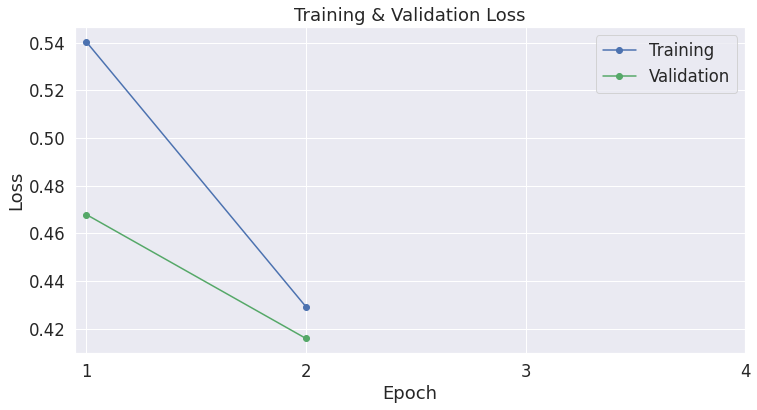

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## bring in 2020 test labels

## Prepare the test set

In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Test Set Predictions

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 300 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (y.sum(), len(y), (y.sum() / len(y) * 100.0)))


Positive samples: 730 of 1565 (46.65%)


In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
f = classification_report(flat_true_labels, flat_predictions, target_names = ["class 0", "class 1"],
                          output_dict = True)
class_f = pd.DataFrame(f).transpose()

In [ ]:
class_f.to_csv(output_name + ".csv")

In [ ]:
class_f

,precision,recall,f1-score,support
class 0,0.89,0.84,0.86,207.00
class 1,0.68,0.76,0.72,93.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.78,0.80,0.79,300.00
weighted avg,0.82,0.81,0.82,300.00


## Lets run our model on the real test data

In [ ]:
checkthat2020 = []
with open("CT20-AR-Test-T1-Tweets.json") as f:
    for line in f:
        checkthat2020.append(json.loads(line))
checkthat2020_test = pd.DataFrame.from_records(checkthat2020)[['full_text']]
checkthat2020_test = checkthat2020_test['full_text'].values

In [ ]:
len(checkthat2020_test)

6000

In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in checkthat2020_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(y_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  #true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 6,000 test sentences...
    DONE.


In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
label_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
raw_predictions = np.concatenate(predictions, axis=0)

#For each sample, pick the label (0 or 1) with the higher score.
soft_predictions = softmax(raw_predictions, axis=1)

## Merge predictions with final dataframe and fix column names

In [ ]:
data = []
with open("CT20-AR-Test-T1-Tweets.json") as f:
    for line in f:
        data.append(json.loads(line))
tweets = pd.DataFrame.from_records(data)

labdf = pd.DataFrame(data=soft_predictions, columns=["label_0", "label_1"])
labdf['score'] = labdf['label_1'] - labdf['label_0']

tweets = tweets[['id', 'full_text', 'topicID']]
#preds = pd.read_table("../results/final/Accenture_bumpy_predictions.txt", header= None)
finalpreds = labdf
tweets['score'] = finalpreds['score']
tweets["rank"] = tweets.groupby("topicID")["score"].rank("dense", ascending=False).astype(int)
tweets = tweets.sort_values(['topicID', 'rank'])
tweets['id'] = tweets['id'].astype(str)

FileNotFoundError: ignored

In [ ]:
tweets.head()

,id,full_text,topicID,score,rank
410,1222607381668024320,#بلجيكا.. وقفة أمام السفارة الأمريكية تنديدا ب...,CT20-AR-01,0.85,1
175,1222274380039888896,#عاجل لجنة المتابعة العليا للقوى الوطنية والإ...,CT20-AR-01,0.82,2
482,1222809405625982978,🔴 تحرك مهم من #تركيا 🇹🇷🇵🇸 \n\nوكالة الأنباء ال...,CT20-AR-01,0.79,3
102,1222234308531904517,مكبرات مساجد الضفة الغربية تصدح بآيات القتال ف...,CT20-AR-01,0.77,4
475,1222644840413839360,إصابة 7 فلسطينيين في مواجهات مع الجيش الإسرائي...,CT20-AR-01,0.76,5


In [ ]:
final = tweets.copy()
final.rename(columns = {"id":"tweetID"}, inplace = True)
final['runID'] = run_name
final = final[['topicID', 'rank', 'tweetID', 'score', 'runID']]

In [ ]:
final.to_csv(run_name + '.txt', sep='\t', index=False)

In [ ]:
extest = pd.read_table(run_name + ".txt", sep = "\t")
extest['tweetID'] = extest['tweetID'].astype(str)
extest['dummy'] = 1
extest = extest[['dummy', 'tweetID']]

In [ ]:
assert len(extest.merge(tweets, left_on='tweetID', right_on='id')) == 6000, "AHHHHHH"